In [1]:
import os
path = os.environ['MyNN']
os.sys.path.append(path)
import MyNN
import gym
import numpy as np
from collections import deque
import _pickle as pickle

import matplotlib.pyplot as plt

In [24]:
class ACAgent:
    def __init__(self, state_size, action_size, variances, gamma=0.995, lam=0.98,
                 actor_lr=0.001, critic_lr=0.001, method='PPO_CEM'):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # discount rate
        self.lam = lam # GAE disc rate
        self.method = method
        self.actor = self._build_model()
        self.critic = self._build_vf()
        self.actor.lr = actor_lr
        self.critic.lr = critic_lr
        self.scaler = MyNN.Scaler(state_size)
        self.variances = variances
        self.replay_buff_x = None
        self.replay_buff_y = None


    def _build_model(self):
        model = MyNN.MyNN(self.state_size)
        model.add(self.state_size*10, 'Tanh')
        model.add(int(np.sqrt(self.action_size*self.state_size)*10), 'Tanh')
        model.add(self.action_size*10, 'Tanh')
        model.add(self.action_size, 'Linear')
        model.compile(self.method, 'Adam')
        return model
    
    def _build_vf(self):
        model = MyNN.MyNN(self.state_size)
        model.add(self.state_size*10, 'Tanh')
        model.add(int(np.sqrt(self.action_size*50)), 'Tanh')
        model.add(5, 'Tanh')
        model.add(1, 'Linear')
        model.compile('MSE', 'Adam')
        return model
    
    def value_function_fit(self, x, y):
        if self.replay_buff_x is None:
            x_train, y_train = x, y
        else:
            x_train = np.hstack([x, self.replay_buff_x])
            y_train = np.hstack([y, self.replay_buff_y])
        self.replay_buff_x = x
        self.replay_buff_y = y
        self.critic.optimize(x_train, y_train, num_epochs=10, 
                             report_cost=False, batch_size=128)

    def get_means(self, state):
        result = self.actor.forward(state, caching='no')
        return result
    
    def update_variances(self, actions, means, adv,old_means, old_var, prob_exp, beta, DKL, DKL_targ, eta):
        var = self.variances
        n = means.shape[1]
        grads = np.square(actions-means)/var
        grads = (grads-1)/(2)
        grads = grads*adv*prob_exp
        DKL_term = (-1/2)*(1 - np.divide(np.square(means-old_means), var) - np.divide(old_var, var))*beta
        if DKL > DKL_targ*2:
            DKL_add_term = (-1/2)*(1 - np.divide(np.square(means-old_means), var) - np.divide(old_var, var))*eta*(2*DKL - 4*DKL_targ)
            DKL_term = DKL_term + DKL_add_term
        grads = (1/n)*(grads + DKL_term)
        grads = np.sum(grads, axis=1, keepdims=True)
        self.variances = np.maximum((np.exp(np.log(var) + self.actor.lr*grads*5e2)), 0.001)
    
    def save(self, name):
        agent.actor.save(path='actor_PPO'+name+'.mnnd')
        agent.critic.save(path='critic_PPO'+name+'.mnnd')
        agent.scaler.save(path='scaler_PPO'+name+'.mnnd')

In [3]:
def running_reward(rewards, gamma):
    result = []
    run_rew = 0
    for reward in  rewards[0,:][::-1]:
        run_rew = run_rew*gamma + reward
        result.append(run_rew)
    return np.array(result[::-1]).reshape(1,-1)

def add_gae(traj, gamma, lam):
    rewards = traj['rewards'] #*(1-gamma)
    values = traj['values']
    traj['tds'] = rewards - values + np.append(traj['values'][0, 1:] * agent.gamma, 0).reshape(1,-1)
    gae = running_reward(traj['tds'], gamma*lam)
    return gae

def compute_DKL(means0, means1, vars0, vars1):
    k = means0.shape[0]
    tr = np.sum(np.divide(vars0, vars1))
    means = np.sum(np.divide(np.square(means1-means0), vars1))
    logs = np.log(np.prod(vars1)) - np.log(np.prod(vars0))
    result = 0.5*(tr + means - k + logs)
    return result/means0.shape[1]

In [4]:
def play_game(agent, render=False):
    state = env.reset().reshape((agent.state_size,1))
    unscaled_states = []
    states = []
    meanss = []
    actions = []
    rewards = []
    done = False
    mean, var = agent.scaler.get()
    while not done:
        if render:
            env.render()
        unscaled_states.append(state)
        scaled_state = (state-mean)/var
        states.append(scaled_state)
        means = agent.get_means(scaled_state)
        meanss.append(means)
        action = means + agent.variances*np.random.normal(size=(agent.action_size,1))
        actions.append(action)
        state, reward, done, _ = env.step(action.T)
        state = state.reshape((agent.state_size,1))
        rewards.append(reward)
        if done:
            break
    return {'unscaled': np.hstack(unscaled_states), 'states' : np.hstack(states),
            'means': np.hstack(meanss), 'actions': np.hstack(actions),
            'rewards': np.array(rewards).reshape(1,-1)}

In [5]:
def play_n_games(agent, n=20):
    trajectories = []
    for i in range(n):
        trajectory = play_game(agent)
        trajectories.append(trajectory)
    return trajectories

In [6]:
def build_train_set(agent, trajectories):
    for traj in trajectories:
        traj['disc_sum_rew'] = running_reward(traj['rewards'], agent.gamma) #*(1-agent.gamma)
        traj['values'] = agent.critic.forward(traj['states'])
        traj['GAE'] = add_gae(traj, agent.gamma, agent.lam)
    X = np.hstack([t['states'] for t in trajectories])
    Y = np.hstack([t['means'] for t in trajectories])
    actions = np.hstack([t['actions'] for t in trajectories])
    disc_sum_rew = np.hstack([t['disc_sum_rew'] for t in trajectories])
    adv = np.hstack([t['GAE'] for t in trajectories])
    adv = (adv - adv.mean())/(adv.std() + 1e-6)
    return X, Y, actions, np.clip(adv, -15, 15), disc_sum_rew

In [31]:
env = gym.make('InvertedPendulum-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
variances = (env.action_space.high - env.action_space.low).reshape(action_size,1)
base_lr = 1e-4
agent = ACAgent(state_size, action_size, actor_lr=base_lr,
                critic_lr=1e-2, gamma=0.95, lam=0.98, method='Cont_PPO',
               variances= variances/2)
d = {'beta': 1, 'eta':30, 'DKL_targ' : 0.003}

In [32]:
results = []
result = 0
best_score = -1000
mean_scores = deque(maxlen=10)
solved = False
variances_list = []
scores = []
adv_data = []
grads_data = []

In [ ]:
%%time
for time in range(1, 2001):
    trajectories = play_n_games(agent, n=10)
    agent.scaler.update(np.hstack([t['unscaled'] for t in trajectories]))
    score = np.mean([(np.sum(t['rewards']), np.var(t['rewards'])) for t in trajectories], axis=0)
    scores.append(score)
    X_batch, d['old_means'], d['actions'], d['adv'], disc_sum_rew = build_train_set(agent, trajectories)
    d['old_vars'] = agent.variances
    print(time, score[0])
    
    for i in range(1,11):
        d['means'] = agent.actor.forward(X_batch)
        agent.actor.cache['A0'] = X_batch
        d['vars'] = agent.variances
        d['DKL'] = compute_DKL(d['old_means'], d['means'], d['old_vars'], d['vars'])
        if d['DKL'] > d['DKL_targ']*4:
            print('Beta is too small, stoped after {} iterations. Increasing beta'.format(i))
            d['beta'] = np.minimum(4, d['beta']*1.44)
            break
        log_p = -0.5*(np.log(d['vars']) + np.divide(np.square(d['actions'] - d['means']), d['vars']))
        log_old_p = -0.5*(np.log(d['old_vars']) + np.divide(np.square(d['actions'] - d['old_means']), d['old_vars']))
        d['prob_exp'] = np.exp(log_p - log_old_p)
        adv_data.append([np.min(d['adv']), np.max(d['adv']), np.mean(np.abs(d['adv']))])
        grads = agent.actor.get_grads(d)
        grads_data.append([np.min(grads), np.max(grads), np.mean(grads), np.mean(np.abs(grads))])
        if np.mean(np.abs(grads)) > 2:
            pickle.dump(d, open('dictionary'+str(time), 'wb'))
        agent.actor.backward(_, _, _, grads=grads)
        agent.actor.number_of_updates +=1
        agent.actor.update_parameters()
        agent.update_variances(d['actions'], d['means'], d['adv'], d['old_means'],
                               d['old_vars'], d['prob_exp'], d['beta'], d['DKL'], d['DKL_targ'], d['eta'])
        
    if d['DKL'] > d['DKL_targ']*2:
        d['beta'] = np.minimum(4, d['beta']*1.2)
        print('Increasing beta')
        if d['beta'] > 3.9:
            agent.actor.lr = np.maximum(agent.actor.lr/1.44, base_lr*0.05)
            d['beta'] = 1
            print('Decreasing learning rate')
    elif d['DKL'] < d['DKL_targ']*0.5:
        d['beta'] = np.maximum(1/4, d['beta']/1.2)
        print('Decreasing beta')
        if d['beta'] < 1/3.9:
            agent.actor.lr = np.minimum(agent.actor.lr*1.2, base_lr*20)
            d['beta'] = 1
            print('Increasing learning rate')
    else:
        print('Beta remains the same')
    
    if score[0] > best_score:
        agent.save('best')
        best_score = score[0]
    mean_scores.append(score[0])
    
    if np.mean(mean_scores) >= 950:
        solved = True
    agent.value_function_fit(X_batch, disc_sum_rew)
    result = result*0.98+score[0]*0.02
    results.append(result)
    variances_list.append(agent.variances)
    
    print('DKL:{:f}, lr: {}, beta: {}'.format(d['DKL'], agent.actor.lr*1e4, d['beta']))
    print('********************************')
    if solved:
        break

1 4.4
Decreasing beta
DKL:0.000293, lr: 1.0, beta: 0.8333333333333334
********************************
2 3.8
Decreasing beta
DKL:0.000235, lr: 1.0, beta: 0.6944444444444445
********************************
3 5.6
Decreasing beta
DKL:0.000263, lr: 1.0, beta: 0.5787037037037038
********************************
4 4.1
Decreasing beta
DKL:0.000364, lr: 1.0, beta: 0.48225308641975323
********************************
5 4.5
Decreasing beta
DKL:0.000205, lr: 1.0, beta: 0.401877572016461
********************************
6 5.0
Decreasing beta
DKL:0.000420, lr: 1.0, beta: 0.3348979766803842
********************************
7 5.8
Decreasing beta
DKL:0.000487, lr: 1.0, beta: 0.2790816472336535
********************************
8 6.5
Decreasing beta
Increasing learning rate
DKL:0.000485, lr: 1.2, beta: 1
********************************
9 6.3
Decreasing beta
DKL:0.000733, lr: 1.2, beta: 0.8333333333333334
********************************
10 5.0
Decreasing beta
DKL:0.000798, lr: 1.2, beta: 0.69444444444

In [10]:
solved

True

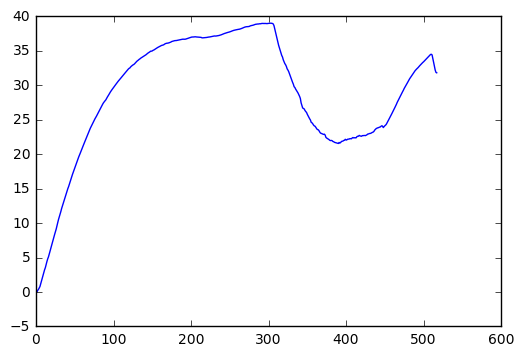

In [10]:
plt.plot(results)
plt.show()

In [11]:
variances_list = np.hstack(variances_list)

In [12]:
variances_list.shape

(2, 518)

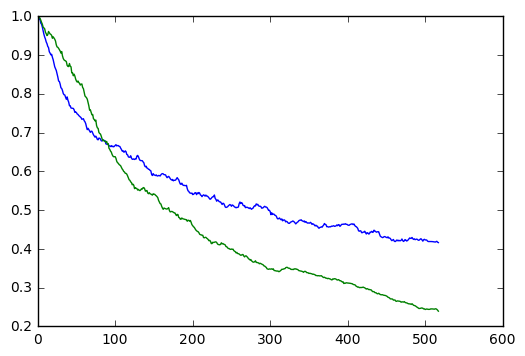

In [13]:
for i in range(2):
    plt.plot(variances_list[i])
plt.show()

In [54]:
agent.critic.load('critic_PPObest.mnnd')
agent.actor.load('actor_PPObest.mnnd')
agent.scaler.load('scaler_PPObest.mnnd')

In [14]:
adv_data = np.vstack(adv_data)

In [15]:
grads_data = np.vstack(grads_data)

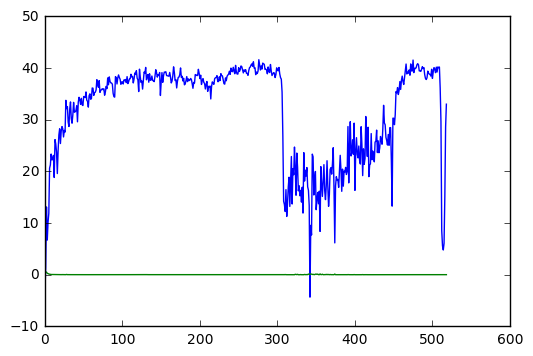

In [16]:
plt.plot(scores)
plt.show()

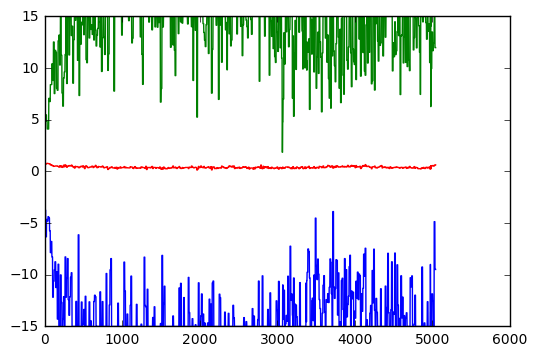

In [17]:
plt.plot(adv_data[:,0])
plt.plot(adv_data[:,1])
plt.plot(adv_data[:,2])
plt.show()

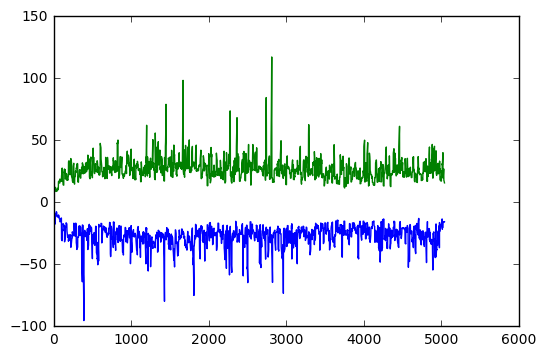

In [18]:
plt.plot(grads_data[:,0])
plt.plot(grads_data[:,1])
plt.show()

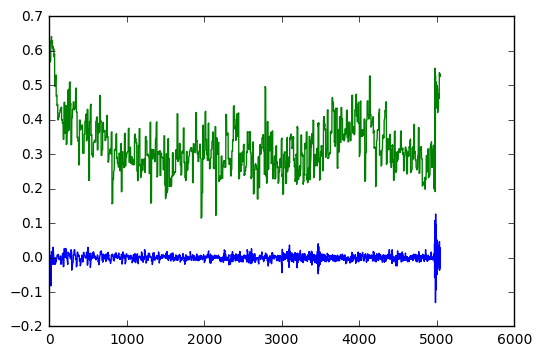

In [19]:
plt.plot(grads_data[:,2])
plt.plot(grads_data[:,3])
plt.show()

In [25]:
traj = play_game(agent, render=True)

In [26]:
np.sum(traj['rewards'])

33.23514626974144

In [27]:
traj['means']

array([[ 0.41667324, -0.91306872, -2.17300432, ..., -0.88807845,
        -0.17305552, -0.89025092],
       [ 1.16266923, -1.12104674, -0.89861608, ..., -1.04588169,
         1.38776643, -1.04587667]])